1. Read the original DenseNet paper, which can be found here: https://arxiv.orgpdf/1608.06993.pdf.
2. There are a few custom building blocks that need to be implemented for a DenseNet model: The composition function, the actual DenseNet block, and the transition block. These can be defined quite straighforwardly using Keras’ functional API.
3. As DenseNets increase the number of feature maps over each DenseNet block, to make the model more compact, also a compression factor can be implemented for the transition block. Here, use a compression factor of θ = 0.5.
4. Note that in the DenseNet paper, a second version is proposed that also includes Bottle- neck layers. You can experiment with those as well, but they may not be needed for the relatively small CIFAR-10 Dataset.
5. As actual architecture, use a network that uses a total of 3 DenseNet blocks, with a growth rate of k = 12. Process the input images as described in the paper.
6. For the classifier part of the network (i.e. the part after the DenseNet blocks) use global averaging pooling, followed by the dense output layer (as in GoogLeNet).
7. There are two sets of experiments reported in the paper for CIFAR-10. One using data augmentation (as we have seen in class) but no dropout, and one using dropout but no data augmentation. Try out both, using a dropout rate of 20%.
8. Evaluate all your models on the test dataset. Which version gives the most accurate results? Does your DenseNet model beat the other models we have seen in class?
9. DSCI 6602 CIFAR-10 competition (optional!): Experiment with various hyper-
parameters (e.g. growth rate, number of layers, number of filters, dropout rate, data augmentation, etc.) and report your best model results by sending me your accuracy score on the testing dataset (train your best model 10 times and send the mean accuracy over all 10 runs). I will keep track of this score and post it on Brightspace.

In [1]:

import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.metrics import confusion_matrix
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.3 MB/s eta 0:00:00


In [2]:
tf.random.set_seed(6602)

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


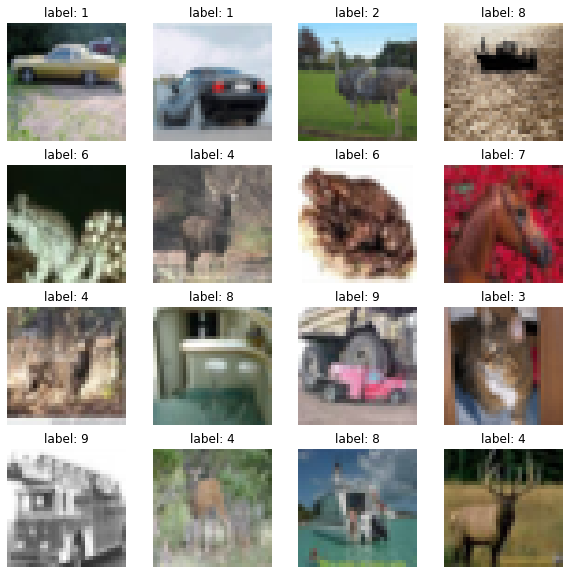

In [4]:
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  i = np.random.randint(5000)
  plt.imshow(X_train[i,])
  plt.title("label: {}" .format(y_train[i,][0]))
  plt.axis("off")

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
# checking for unique values in y_test and y_train
print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [7]:
y_train = tf.keras .utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras .utils.to_categorical(y_test, num_classes=10)

In [8]:
# this determines the normalization factor
print("Min value:", np.min(X_train))
print("Max value:", np.max(X_train))

Min value: 0
Max value: 255


In [9]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train = X_train / 255
X_test = X_test / 255

In [10]:
def densenet(input_shape, n_classes, f=12):

  # Define composite function block
  def bn_relu_conv(x, f, k, dropout=0.2):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(f, (3,3), padding="same")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x
  
  # Define main DenseNet block
  def dense_block(x, r, f, dropout=0.2, bottleneck=True):
    for _ in range(r):
      if bottleneck:
        y = bn_relu_conv(x, 4*f, 1, dropout=dropout)
      else:
        y = x
      y = bn_relu_conv(y, f, 3)
      x = tf.keras.layers.Concatenate()([y, x])
    return x

  # Define the transition layer
  def transition_layer(x, dropout=0.2):
    f = tf.keras.backend.int_shape(x)[-1]
    f = int(f * 0.5) # compression factor is 0.5 
    x = bn_relu_conv(x, f, (1,1))
    x = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2)(x)
    return x

  input_layer = tf.keras.layers.Input(shape = input_shape)
  x = tf.keras.layers.Conv2D(16, 3, strides=2, padding="same")(input_layer)
  x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

  for r in [6,12,24]:
    d = dense_block(x, r, f)
    x = transition_layer(d)

  x = tf.keras.layers.GlobalAveragePooling2D()(d)
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

  model = tf.keras.models.Model(input_layer, output)
  return model

# Set the input shape and number of classes
input_shape = X_train[0].shape
n_classes = 10

# Create the Densenet model
model = densenet(input_shape, n_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   448         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 16)     0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 16)    64          ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [11]:
# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [12]:
# Step 4: Train the model
hist = model.fit(
    X_train, y_train, batch_size=32,
    epochs=10,
    validation_split= 0.1,
    callbacks = tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
1407/1407 [==============================] - 204s 89ms/step - loss: 1.5408 - accuracy: 0.4418 - val_loss: 1.4504 - val_accuracy: 0.5100
Epoch 2/10
1407/1407 [==============================] - 120s 85ms/step - loss: 1.1908 - accuracy: 0.5750 - val_loss: 1.1741 - val_accuracy: 0.6120
Epoch 3/10
1407/1407 [==============================] - 120s 86ms/step - loss: 1.0428 - accuracy: 0.6338 - val_loss: 1.3811 - val_accuracy: 0.5514
Epoch 4/10
1407/1407 [==============================] - 120s 86ms/step - loss: 0.9318 - accuracy: 0.6730 - val_loss: 1.5234 - val_accuracy: 0.5422
Epoch 5/10
1407/1407 [==============================] - 121s 86ms/step - loss: 0.8597 - accuracy: 0.6969 - val_loss: 1.0183 - val_accuracy: 0.6766
Epoch 6/10
1407/1407 [==============================] - 120s 85ms/step - loss: 0.7981 - accuracy: 0.7211 - val_loss: 0.9129 - val_accuracy: 0.6958
Epoch 7/10
1407/1407 [==============================] - 120s 85ms/step - loss: 0.7471 - accuracy: 0.7399 - val_loss: 0

In [13]:
def plot_history(hist):

  train_loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  train_acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  plt.figure(figsize=(10,10))

  plt.subplot(121)
  plt.plot(np.arange(1,len(train_loss)+1), train_loss)
  plt.plot(np.arange(1,len(train_loss)+1), val_loss)
  plt.legend(['train','validation'])
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.subplot(122)
  plt.plot(np.arange(1,len(train_loss)+1), train_acc)
  plt.plot(np.arange(1,len(train_loss)+1), val_acc)
  plt.legend(['train','validation'])
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

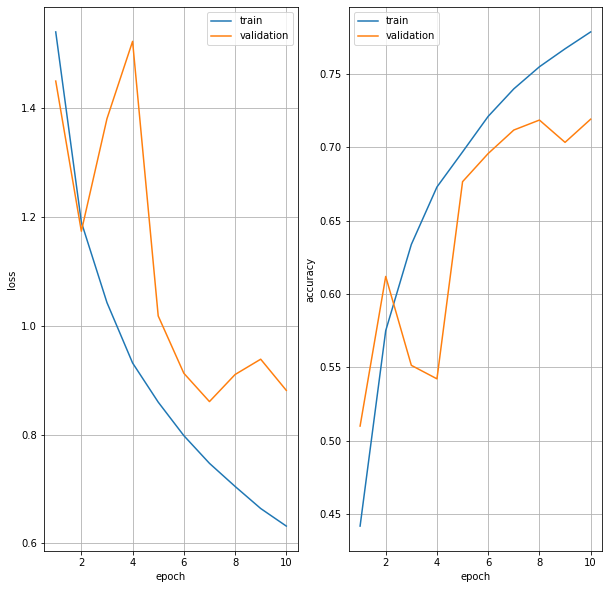

In [14]:
plot_history(hist)

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 6s 20ms/step - loss: 0.8784 - accuracy: 0.7212


In [16]:
print('Accuracy on test data: {}' .format(test_accuracy))

Accuracy on test data: 0.7211999893188477


### DATA AUGMENTATION WITH NO DROPOUT

In [17]:
def densenet(input_shape, n_classes, f=12):

  # Define composite function block
  def bn_relu_conv(x, f, k, dropout=0.0):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(f, (3,3), padding="same")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x
  
  # Define main DenseNet block
  def dense_block(x, r, f, dropout=0.0, bottleneck=True):
    for _ in range(r):
      if bottleneck:
        y = bn_relu_conv(x, 4*f, 1, dropout=dropout)
      else:
        y = x
      y = bn_relu_conv(y, f, 3)
      x = tf.keras.layers.Concatenate()([y, x])
    return x

  # Define the transition layer
  def transition_layer(x, dropout=0.0):
    f = tf.keras.backend.int_shape(x)[-1]
    f = int(f * 0.5) # compression factor is 0.5
    x = bn_relu_conv(x, f, (1,1))
    x = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2)(x)
    return x

  input_layer = tf.keras.layers.Input(shape = input_shape)
  x = tf.keras.layers.Conv2D(16, 3, strides=2, padding="same")(input_layer)
  x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

  for r in [6,12,24]:
    d = dense_block(x, r, f)
    x = transition_layer(d)

  x = tf.keras.layers.GlobalAveragePooling2D()(d)
  output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

  model1 = tf.keras.models.Model(input_layer, output)
  return model1

# Set the input shape and number of classes
input_shape = X_train[0].shape
n_classes = 10

# Create the Densenet model
model1 = densenet(input_shape, n_classes)
model1.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_88 (Conv2D)             (None, 16, 16, 16)   448         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 16)    0           ['conv2d_88[0][0]']              
                                                                                                  
 batch_normalization_87 (BatchN  (None, 8, 8, 16)    64          ['max_pooling2d_1[0][0]']        
 ormalization)                                                                              

In [18]:
# Compile the model, i.e. associate a loss function and the chosen variant of GD`
model1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [19]:
from sklearn.model_selection import train_test_split
# Define the data augmentation pipeline
image_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode='nearest')

# Create a generator for the training data
image_gen = image_aug.flow(X_train, y_train, batch_size=64)


# Assign training data into training and validation
XXtrain, XX_val, yy_train, yy_val = train_test_split(X_train, y_train, test_size=0.1)

hist1 = model1.fit(image_gen, epochs=10, batch_size=32, validation_data=(XX_val, yy_val), callbacks = tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
782/782 [==============================] - 136s 101ms/step - loss: 1.6027 - accuracy: 0.4153 - val_loss: 1.6847 - val_accuracy: 0.4680
Epoch 2/10
782/782 [==============================] - 78s 99ms/step - loss: 1.2815 - accuracy: 0.5366 - val_loss: 1.8859 - val_accuracy: 0.4852
Epoch 3/10
782/782 [==============================] - 77s 99ms/step - loss: 1.1221 - accuracy: 0.6013 - val_loss: 1.2898 - val_accuracy: 0.5710
Epoch 4/10
782/782 [==============================] - 76s 98ms/step - loss: 1.0115 - accuracy: 0.6422 - val_loss: 1.1530 - val_accuracy: 0.6078
Epoch 5/10
782/782 [==============================] - 81s 103ms/step - loss: 0.9454 - accuracy: 0.6680 - val_loss: 0.9139 - val_accuracy: 0.6862
Epoch 6/10
782/782 [==============================] - 77s 98ms/step - loss: 0.8830 - accuracy: 0.6910 - val_loss: 0.8778 - val_accuracy: 0.6960
Epoch 7/10
782/782 [==============================] - 77s 99ms/step - loss: 0.8388 - accuracy: 0.7059 - val_loss: 1.1089 - val_accura

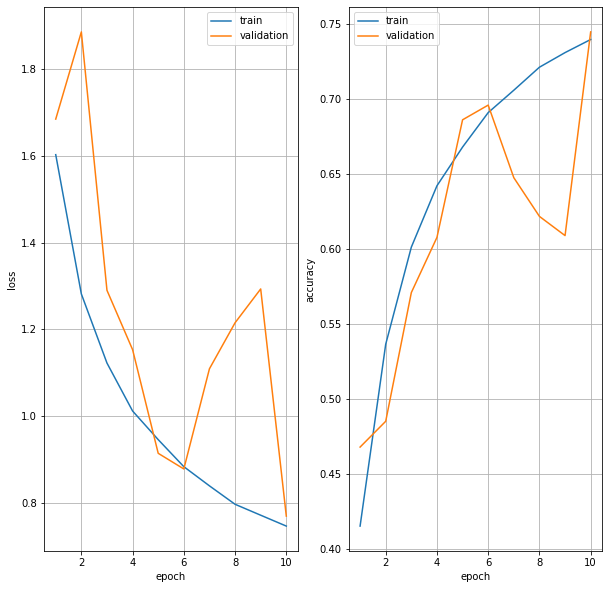

In [20]:
plot_history(hist1)

In [21]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.8527 - accuracy: 0.7149


In [22]:
print('Accuracy on test data: {}' .format(test_accuracy))

Accuracy on test data: 0.714900016784668
